<a href="https://colab.research.google.com/github/petal-cs-pitt/petal-cs-pitt.github.io/blob/master/Intent_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.0MB 18.4MB/s 
     |████████████████████████████████| 890kB 56.2MB/s 
     |████████████████████████████████| 3.2MB 51.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=9af2c55f4756795a2e0607289df0a1763283573045f7970f78bf2e3718a39714
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
import pandas as pd

In [ ]:
data_df = pd.read_pickle('/content/drive/My Drive/PersuasionForGood_Data/Indent_Data.pkl')

In [ ]:
data_df.head()

,er_last_turn,er_last_sent,er_act,ee_sent,ee_act,ee_sentiment
0,Hello. How are you?,How are you?,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","I'm good, how are you doing?",7,"[0.4404, 0.0, 0.633, 0.367]"
1,Very well. I'm just up organizing info for my ...,Are you involved with charities?,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Yes!,12,"[0.4574, 0.0, 0.0, 1.0]"
2,Very well. I'm just up organizing info for my ...,Are you involved with charities?,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",I work with children who have terminal illnesses.,12,"[-0.4939, 0.314, 0.686, 0.0]"
3,Very well. I'm just up organizing info for my ...,Are you involved with charities?,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",What charity are you involved in?,14,"[0.4215, 0.0, 0.641, 0.359]"
4,That's great! I help with Save The Children.,I help with Save The Children.,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",Amazing!,0,"[0.6239, 0.0, 0.0, 1.0]"


In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

n = data_df.shape[0]

max_len = 0
for i in range(n):
  er = data_df.iloc[i, 0]
  ee = data_df.iloc[i, 3]
  encoded_text = tokenizer.encode(ee, add_special_tokens=True)  # Change here if want to add er
  max_len = max(max_len, len(encoded_text))

max_len

62

In [ ]:
MAX_LEN = max_len+3

In [ ]:
from sklearn.model_selection import train_test_split

X = data_df.iloc[:, [1, 3, 2, 5]]
y = data_df['ee_act']


X = X.to_numpy()
y = y.to_numpy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2020)
X[1:2, :]

array([['Are you involved with charities?', 'Yes!',
        array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0]),
        list([0.4574, 0.0, 0.0, 1.0])]], dtype=object)

In [ ]:
# Create a function to tokenize a set of texts
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    token_type_ids = []
    er_acts = []
    ee_sentiments = []
    other_features = []
    # For every sentence...
    for row in data:
      er_ut = row[0]
      ee_ut = row[1]
      # `encode_plus` will:
      #    (1) Tokenize the sentence
      #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
      #    (3) Truncate/Pad sentence to max length
      #    (4) Map tokens to their IDs
      #    (5) Create attention mask
      #    (6) Return a dictionary of outputs
      encoded_sent = tokenizer(
          text=ee_ut,  # Preprocess sentence
          #text_pair=ee_ut,
          add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
          max_length=MAX_LEN,                  # Max length to truncate/pad
          padding='max_length',         # Pad sentence to max length
          #return_tensors='pt',           # Return PyTorch tensor                          
          return_attention_mask=True,      # Return attention mask
          return_token_type_ids=True,
          )
      
      # Add the outputs to the lists
      input_ids.append(encoded_sent.get('input_ids'))
      attention_masks.append(encoded_sent.get('attention_mask'))
      token_type_ids.append(encoded_sent.get('token_type_ids'))
      other_features.append(np.concatenate((row[2], row[3]), axis=None))
      #er_acts.append(row[2])
      #ee_sentiments.append(row[3])

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    token_type_ids = torch.tensor(token_type_ids)

    #return input_ids, attention_masks, token_type_ids
    return input_ids, attention_masks, token_type_ids, torch.tensor(other_features)

In [ ]:
import torch

train_inputs, train_masks, train_segments, train_features = preprocessing_for_bert(X_train)
val_inputs, val_masks, val_segments, val_features = preprocessing_for_bert(X_val)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_segments, train_features, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_segments, val_features, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [ ]:
ee_intent_dict = {'acknowledgement': 0, 'agree-donation': 1, 'ask-donation-procedure': 2, 'ask-org-info': 3, 'ask-persuader-donation-intention': 4,
                  'closing': 5, 'confirm-donation': 1, 'disagree-donation': 6, 'greeting': 7, 'negative-reaction-to-donation': 8, 'negative-to-inquiry': 9, 'neutral-reaction-to-donation': 10,
                  'neutral-to-inquiry': 10, 'off-task': 10, 'other': 10, 'personal-related-inquiry': 11, 'positive-reaction-to-donation': 0, 'positive-to-inquiry': 12, 'provide-donation-amount': 13,
                  'task-related-inquiry': 14, 'thank': 5, 'you-are-welcome': 5}

N_CLASSES = len(set(ee_intent_dict.values()))
N_CLASSES

15

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, other_features_size, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768+other_features_size, 50, N_CLASSES

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(D_in, D_out)
            #nn.Linear(D_in, H),
            #nn.ReLU(),
            #nn.Dropout(0.5),
            #nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask, token_type_ids, other_features):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            #token_type_ids=token_type_ids,  # Add token_type_ids if use pair
                            attention_mask=attention_mask)
                            
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]
        # last_hidden_state_cls = nn.Dropout(0.4)(last_hidden_state_cls)
        final_representation = torch.cat((last_hidden_state_cls, other_features), 1)
        # Feed input to classifier to compute logits
        logits = self.classifier(final_representation)

        return logits

CPU times: user 21.3 ms, sys: 0 ns, total: 21.3 ms
Wall time: 26.1 ms


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(train_dataloader, epochs=4, freeze_bert=False):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(other_features_size = features.shape[1], freeze_bert=freeze_bert)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
er_act_map = {'acknowledgement': 0,
 'ask-donate-more': 1,
 'ask-donation-amount': 2,
 'ask-not-donate-reason': 3,
 'closing': 4,
 'comment-partner': 5,
 'confirm-donation': 6,
 'credibility-appeal': 7,
 'donation-information': 8,
 'emotion-appeal': 9,
 'foot-in-the-door': 10,
 'greeting': 11,
 'logical-appeal': 12,
 'negative-to-inquiry': 13,
 'neutral-to-inquiry': 14,
 'off-task': 15,
 'other': 16,
 'personal-related-inquiry': 17,
 'personal-story': 18,
 'positive-to-inquiry': 19,
 'praise-user': 20,
 'proposition-of-donation': 21,
 'self-modeling': 22,
 'source-related-inquiry': 23,
 'task-related-inquiry': 24,
 'thank': 25,
 'you-are-welcome': 26}

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()


def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    f1_each = 0
    f1_s = 0
    c_mat = None
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'F1':^4} | {'Elapsed':^9}")
        print("-"*75)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_segment_ids, b_other_features, b_labels = batch

            b_input_ids = b_input_ids.type(torch.IntTensor).to(device)
            b_attn_mask = b_attn_mask.type(torch.IntTensor).to(device)
            b_segment_ids = b_segment_ids.type(torch.IntTensor).to(device)
            b_labels = b_labels.type(torch.LongTensor).to(device)
            b_other_features = b_other_features.to(device).float()

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask, b_segment_ids, b_other_features)
            #print(logits)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss
            total_loss += loss

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {'-':^4} |{time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*75)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy, f1_s, f1_each, c_mat = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {f1_s:^4.2f} | {time_elapsed:^9.2f}")
            print("-"*75)
        print("\n")
    return f1_s, f1_each, c_mat
    print("Training complete!")

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def predict(preds, other_features):
    new_preds = []
    for i in range(other_features.shape[0]):
      pred = preds[i]
      features = other_features[i, :]
      new_pred = pred
      if pred == 0: #pos-to-dona
        inq1 = er_act_map['personal-related-inquiry']
        inq2 = er_act_map['source-related-inquiry']
        inq3 = er_act_map['task-related-inquiry']
        if features[inq1] == 1 or features[inq2] == 1 or features[inq3] == 1:
          new_pred = 12
      elif pred == 12: #pos_to_inq
        inq1 = er_act_map['personal-related-inquiry']
        inq2 = er_act_map['source-related-inquiry']
        inq3 = er_act_map['task-related-inquiry']
        if features[inq1] == 0 and features[inq2] == 0 and features[inq3] == 0:
          new_pred = 0
      elif pred == 8: #negative-do => dis-do
        proposed_donation = er_act_map['proposition-of-donation']
        if features[proposed_donation] == 1:
          new_pred = 6
      elif pred == 14: #ask-org-info => task-related-inq (14)
        cred_appeal = er_act_map['credibility-appeal']
        if features[cred_appeal] == 1:
          new_pred = 3

      new_preds.append(new_pred)
    return new_preds

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []
    all_preds = []
    y_val = []
    true_cnt = 0
    data_cnt = 0
    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_segment_ids, b_other_features, b_labels = batch

        true_labels = b_labels.cpu().numpy()
        y_val.extend(true_labels)

        data_cnt = data_cnt + true_labels.shape[0]
        b_input_ids = b_input_ids.type(torch.IntTensor).to(device)
        b_attn_mask = b_attn_mask.type(torch.IntTensor).to(device)
        b_segment_ids = b_segment_ids.type(torch.IntTensor).to(device)
        b_labels = b_labels.type(torch.LongTensor).to(device)
        b_other_features = b_other_features.to(device).float()

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask, b_segment_ids, b_other_features)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten().cpu().numpy()
        all_preds.extend(predict(preds, b_other_features.cpu().numpy()))
        # Calculate the accuracy rate
    
        true_cnt = true_cnt + np.sum((preds == true_labels))
        #print(preds)
        #print(true_labels)
        
    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = true_cnt / data_cnt

    f1_s = f1_score(y_val, all_preds, average='macro')
    f1_each = f1_score(y_val, all_preds, average=None)
    c_mat = confusion_matrix(y_val, all_preds)

    return val_loss, val_accuracy, f1_s, f1_each, c_mat

In [ ]:
inputs, masks, segments, features = preprocessing_for_bert(X)
labels = torch.tensor(y)

In [ ]:
X[1, :]

array(['Are you involved with charities?', 'Yes!',
       array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0]),
       list([0.4574, 0.0, 0.0, 1.0])], dtype=object)

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(14, 14))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
set_seed(12)

# Cross-validation

dataset = TensorDataset(inputs, masks, segments, features, labels)

batch_size = 32

In [ ]:
from sklearn.model_selection import KFold

num_folds = 5
num_epochs = 4
kfold = KFold(n_splits=num_folds, shuffle=True)

f1_per_class = np.zeros(N_CLASSES)
f1_avg = 0
C_mat = np.zeros((N_CLASSES, N_CLASSES))

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
  print(f'FOLD {fold}')
  print('--------------------------------')
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(
                    dataset, batch_size=batch_size, sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader(
                    dataset, batch_size=batch_size, sampler=test_subsampler)

  bert_classifier, optimizer, scheduler = initialize_model(trainloader, epochs=num_epochs, freeze_bert=False)
  f1_s, f1_each, c_mat = train(bert_classifier, trainloader, testloader, epochs=num_epochs, evaluation=True)  
  f1_avg = f1_avg + f1_s
  f1_per_class = f1_per_class + f1_each
  C_mat = C_mat + c_mat
  if fold == 0:
    break

f1_per_class = f1_per_class / num_folds
f1_avg = f1_avg / num_folds
C_mat = C_mat / num_folds

FOLD 0
--------------------------------
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  F1  |  Elapsed 
---------------------------------------------------------------------------
   1    |   20    |   2.305933   |     -      |     -     |  -   |  8.41   
   1    |   40    |   1.735314   |     -      |     -     |  -   |  8.16   
   1    |   60    |   1.508942   |     -      |     -     |  -   |  8.08   
   1    |   80    |   1.377777   |     -      |     -     |  -   |  7.87   
   1    |   100   |   1.322214   |     -      |     -     |  -   |  7.71   
   1    |   120   |   1.222749   |     -      |     -     |  -   |  7.54   
---------------------------------------------------------------------------
   1    |    -    |   1.584831   |  1.193403  |   0.60    | 0.52 |   51.94  
---------------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  F1  |  Elapsed 
------------------------

In [ ]:
C_mat = C_mat * num_folds

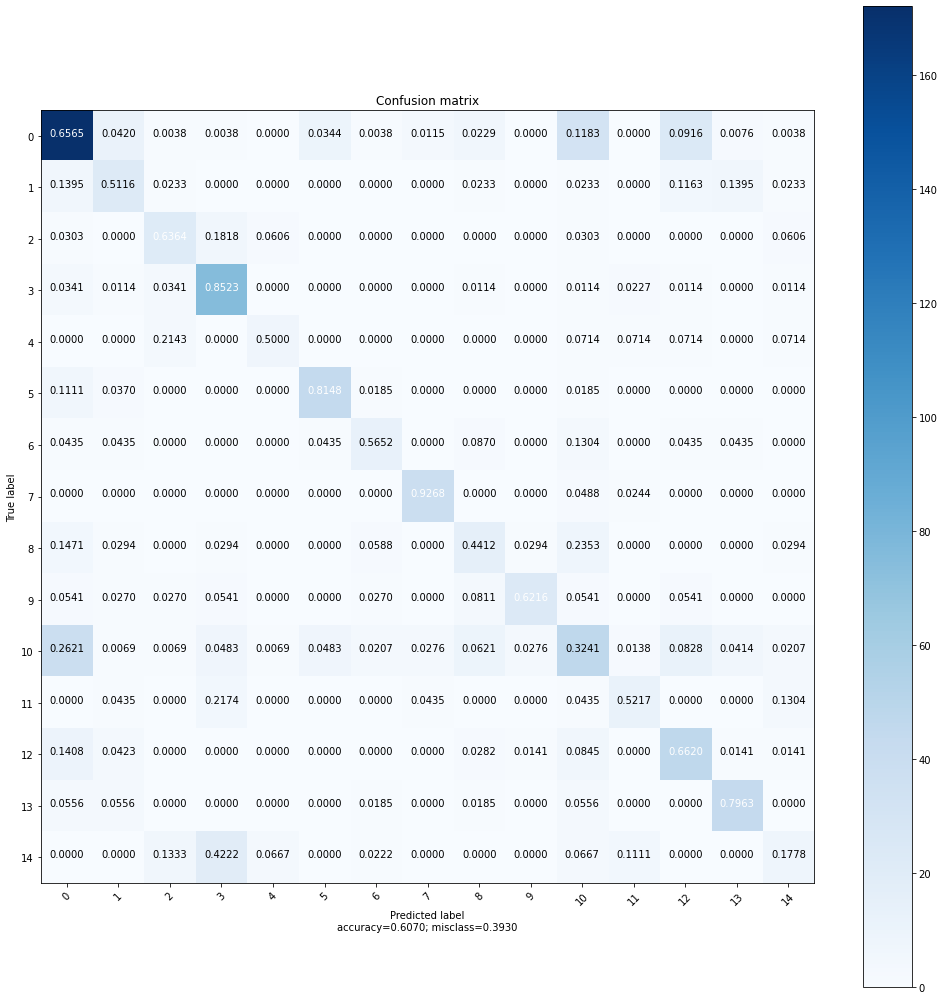

In [ ]:
plot_confusion_matrix(C_mat, range(0, N_CLASSES), normalize=True)

In [ ]:
np.sum(C_mat)

967.0

In [ ]:
ee_intent_dict

{'acknowledgement': 0,
 'agree-donation': 1,
 'ask-donation-procedure': 2,
 'ask-org-info': 3,
 'ask-persuader-donation-intention': 4,
 'closing': 5,
 'confirm-donation': 1,
 'disagree-donation': 6,
 'greeting': 7,
 'negative-reaction-to-donation': 8,
 'negative-to-inquiry': 9,
 'neutral-reaction-to-donation': 10,
 'neutral-to-inquiry': 10,
 'off-task': 10,
 'other': 10,
 'personal-related-inquiry': 11,
 'positive-reaction-to-donation': 0,
 'positive-to-inquiry': 12,
 'provide-donation-amount': 13,
 'task-related-inquiry': 14,
 'thank': 5,
 'you-are-welcome': 5}

In [ ]:
ee_intent_dict

{'acknowledgement': 0,
 'agree-donation': 1,
 'ask-donation-procedure': 2,
 'ask-org-info': 3,
 'ask-persuader-donation-intention': 4,
 'closing': 5,
 'confirm-donation': 1,
 'disagree-donation': 6,
 'greeting': 7,
 'negative-reaction-to-donation': 8,
 'negative-to-inquiry': 9,
 'neutral-reaction-to-donation': 10,
 'neutral-to-inquiry': 10,
 'off-task': 10,
 'other': 10,
 'personal-related-inquiry': 11,
 'positive-reaction-to-donation': 12,
 'positive-to-inquiry': 13,
 'provide-donation-amount': 14,
 'task-related-inquiry': 15,
 'thank': 5,
 'you-are-welcome': 5}

In [ ]:
# Train with all data
all_loader = torch.utils.data.DataLoader(
                    dataset, batch_size=batch_size)
bert_classifier, optimizer, scheduler = initialize_model(all_loader, epochs=num_epochs, freeze_bert=False)
f1_s, f1_per_class, C_mat = train(bert_classifier, all_loader, all_loader, epochs=num_epochs, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  F1  |  Elapsed 
---------------------------------------------------------------------------
   1    |   20    |   2.295219   |     -      |     -     |  -   |  8.06   
   1    |   40    |   1.796667   |     -      |     -     |  -   |  7.86   
   1    |   60    |   1.548014   |     -      |     -     |  -   |  7.94   
   1    |   80    |   1.356977   |     -      |     -     |  -   |  7.82   
   1    |   100   |   1.344097   |     -      |     -     |  -   |  7.72   
   1    |   120   |   1.263111   |     -      |     -     |  -   |  7.66   
   1    |   140   |   1.264358   |     -      |     -     |  -   |  7.59   
   1    |   150   |   1.354470   |     -      |     -     |  -   |  3.78   
---------------------------------------------------------------------------
   1    |    -    |   1.544429   |  0.978963  |   0.68    | 0.60 |   78.88  
-------------------------------------------------------------------

In [ ]:
torch.save(bert_classifier, '/content/drive/My Drive/PersuasionForGood_Data/Models/ee_only.pt')

In [ ]:
torch.save(bert_classifier, '/content/drive/My Drive/PersuasionForGood_Data/Models/last_ee_sent2.pt')

In [ ]:
my_model = torch.load('/content/drive/My Drive/PersuasionForGood_Data/Models/ee_only.pt')
my_model.eval()

In [ ]:
my_model = bert_classifier
my_model.eval()

In [ ]:
all_loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=batch_size)
all_preds = []
cnt = 0
y_true = []
for batch in all_loader:
  # Load batch to GPU
  b_input_ids, b_attn_mask, b_segment_ids, b_other_features, b_labels = batch

  true_labels = b_labels.cpu().numpy()
  y_true.extend(true_labels)
                
  b_input_ids = b_input_ids.type(torch.IntTensor).to(device)
  b_attn_mask = b_attn_mask.type(torch.IntTensor).to(device)
  b_segment_ids = b_segment_ids.type(torch.IntTensor).to(device)
  b_labels = b_labels.type(torch.LongTensor).to(device)
  b_other_features = b_other_features.to(device).float()

  # Compute logits
  with torch.no_grad():
      logits = my_model(b_input_ids, b_attn_mask, b_segment_ids, b_other_features)


  # Get the predictions
  preds = torch.argmax(logits, dim=1).flatten().cpu().numpy()
  all_preds.extend(preds)
  cnt = cnt + np.sum((preds == true_labels))
acc = np.sum(np.asarray(all_preds) == np.asarray(y_true))/len(y_true)
f1_s = f1_score(y_true, all_preds, average='macro')
f1_per_class = f1_score(y_true, all_preds, average=None)
C_mat = confusion_matrix(y_true, all_preds)

In [ ]:
acc

0.8770695364238411

In [ ]:
f1_s

0.8567321390258698

In [ ]:
f1_per_class

array([0.91888011, 0.81702128, 0.83783784, 0.91658489, 0.83243243,
       0.9435337 , 0.89932886, 0.96688742, 0.84415584, 0.89726027,
       0.82021661, 0.7804878 , 0.82899628, 0.94285714, 0.60450161])

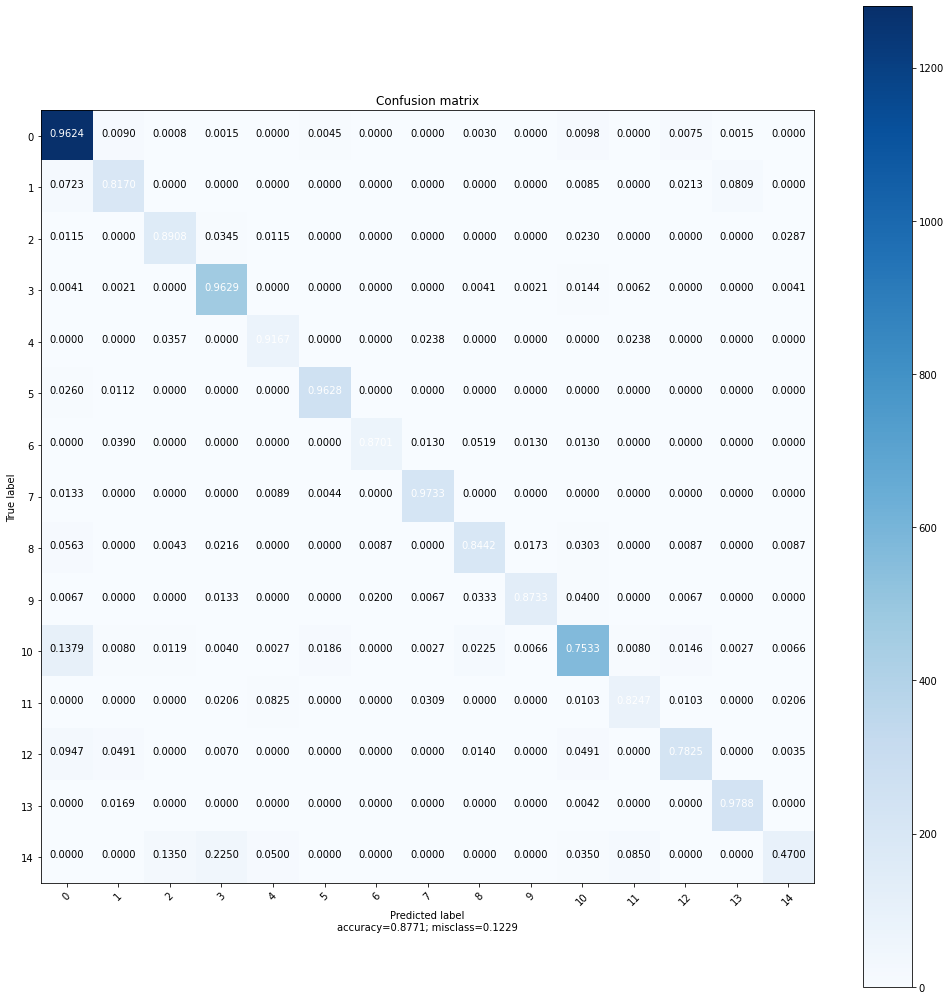

In [ ]:
plot_confusion_matrix(C_mat, range(0, N_CLASSES), normalize=True)

In [ ]:
ee_intent_dict

{'acknowledgement': 0,
 'agree-donation': 1,
 'ask-donation-procedure': 2,
 'ask-org-info': 3,
 'ask-persuader-donation-intention': 4,
 'closing': 5,
 'confirm-donation': 1,
 'disagree-donation': 6,
 'greeting': 7,
 'negative-reaction-to-donation': 8,
 'negative-to-inquiry': 9,
 'neutral-reaction-to-donation': 10,
 'neutral-to-inquiry': 10,
 'off-task': 10,
 'other': 10,
 'personal-related-inquiry': 11,
 'positive-reaction-to-donation': 0,
 'positive-to-inquiry': 12,
 'provide-donation-amount': 13,
 'task-related-inquiry': 14,
 'thank': 5,
 'you-are-welcome': 5}